# Per-Table DP-SGD Synthesis

The wide-table DP-SGD approach (notebook 05) failed because extreme sparsity (93-99% zeros in metric columns) caused the VAE to collapse all continuous outputs to near-zero. This notebook takes a different approach: synthesize each reporting table independently, then stitch them together via probabilistic guid assignment.

The tradeoff is explicit. Per-table synthesis destroys cross-table correlations (a synthetic guid's chassis type has no relationship to its battery usage pattern), but eliminates the zero-inflation problem because each table is trained only on rows that actually exist.

Privacy budget: epsilon=4.0 per table. Under basic composition, the total privacy cost for k tables is k * epsilon. This is standard practice in per-table synthesis; the alternative (splitting a single epsilon across all tables) yields epsilon/k per table, which is too small to be useful.

---
## Step 1: Imports and configuration

In [1]:
import sys
import time
import warnings
from pathlib import Path

import duckdb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from IPython.display import display, Markdown
from opacus import PrivacyEngine
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")

REPORTING_DIR = Path("../data/reporting")
SYNTH_DIR = Path("../data/reporting/synth_pertable")
RESULTS_REAL = Path("../data/results/real")
RESULTS_SYNTH = Path("../data/results/synth_pertable")
QUERIES_DIR = Path("../docs/queries")
MODELS_DIR = Path("../data/models/pertable")

SYNTH_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_SYNTH.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

TARGET_EPSILON = 4.0
DELTA = 1e-5
MAX_GRAD_NORM = 1.0

device = torch.device("cpu")

display(Markdown(f"Device: `{device}`"))

Device: `cpu`

---
## Step 2: Load all reporting tables

In [2]:
TABLE_NAMES = [
    "system_sysinfo_unique_normalized",
    "system_cpu_metadata",
    "system_os_codename_history",
    "system_network_consumption",
    "system_memory_utilization",
    "system_pkg_C0",
    "system_psys_rap_watts",
    "system_pkg_avg_freq_mhz",
    "system_pkg_temp_centigrade",
    "system_hw_pkg_power",
    "system_batt_dc_events",
    "system_web_cat_usage",
    "system_web_cat_pivot_duration",
    "system_on_off_suspend_time_day",
    "system_display_devices",
    "system_userwait",
    "system_frgnd_apps_types",
    "system_mods_top_blocker_hist",
    "system_mods_power_consumption",
]

tables = {}
con = duckdb.connect()

for name in TABLE_NAMES:
    path = REPORTING_DIR / f"{name}.parquet"
    if path.exists():
        nrows = con.execute(f"SELECT COUNT(*) FROM read_parquet('{path}')").fetchone()[0]
        nguids = con.execute(f"SELECT COUNT(DISTINCT guid) FROM read_parquet('{path}')").fetchone()[0]
        tables[name] = {"path": path, "nrows": nrows, "nguids": nguids}

summary = pd.DataFrame([
    {"table": k, "rows": v["nrows"], "guids": v["nguids"]}
    for k, v in tables.items()
]).sort_values("rows", ascending=False).reset_index(drop=True)

display(Markdown(f"Loaded {len(tables)} reporting tables."))
display(summary)

Loaded 19 reporting tables.

,table,rows,guids
0,system_display_devices,220997262,209239
1,system_mods_top_blocker_hist,92460980,65034
2,system_frgnd_apps_types,56755998,55830
3,system_userwait,34655557,38142
4,system_web_cat_usage,21354922,64276
5,system_memory_utilization,11671422,69514
6,system_network_consumption,5721356,37224
7,system_web_cat_pivot_duration,4537100,64276
8,system_on_off_suspend_time_day,1582017,36958
9,system_sysinfo_unique_normalized,1000000,1000000


In [3]:
_EXPECTED_PERTABLE = [
    "system_sysinfo_unique_normalized", "system_cpu_metadata",
    "system_os_codename_history", "system_network_consumption",
    "system_memory_utilization", "system_batt_dc_events",
    "system_web_cat_usage", "system_web_cat_pivot_duration",
    "system_on_off_suspend_time_day", "system_display_devices",
    "system_userwait", "system_frgnd_apps_types",
    "system_mods_top_blocker_hist", "system_mods_power_consumption",
    "system_pkg_C0", "system_psys_rap_watts",
    "system_pkg_avg_freq_mhz", "system_pkg_temp_centigrade",
    "system_hw_pkg_power",
]

_PERTABLE_CACHED = all((SYNTH_DIR / f"{t}.parquet").exists() for t in _EXPECTED_PERTABLE)

if _PERTABLE_CACHED:
    _PT_CACHE = {t: pd.read_parquet(SYNTH_DIR / f"{t}.parquet") for t in _EXPECTED_PERTABLE}
    display(Markdown(f"Found {len(_PT_CACHE)} cached per-table synthetic parquets in `{SYNTH_DIR}`. Skipping synthesis."))
else:
    _PT_CACHE = {}
    display(Markdown("No complete cache found. Will run synthesis."))

Found 19 cached per-table synthetic parquets in `../data/reporting/synth_pertable`. Skipping synthesis.

---
## Step 3: Synthesize sysinfo via DP-VAE

Sysinfo is the anchor table (1M rows, one per guid). It contains 9 categorical columns and 1 numeric column (ram). A DP-VAE captures the joint distribution of chassis type, country, vendor, OS, CPU, and persona.

In [4]:
SYSINFO_CAT_COLS = [
    "chassistype", "countryname_normalized", "modelvendor_normalized",
    "os", "cpuname", "cpucode", "cpu_family", "persona", "processornumber",
]
SYSINFO_NUM_COLS = ["ram"]
SYSINFO_EXTRA_COLS = ["model_normalized", "#ofcores"]
TOP_K = 50

sysinfo_path = tables["system_sysinfo_unique_normalized"]["path"]
sysinfo_df = con.execute(
    f"SELECT guid, {', '.join(SYSINFO_CAT_COLS)}, {', '.join(SYSINFO_NUM_COLS)}, "
    f"""{', '.join(f'"{c}"' if '#' in c else c for c in SYSINFO_EXTRA_COLS)} """
    f"FROM read_parquet('{sysinfo_path}')"
).df()

for col in SYSINFO_CAT_COLS:
    sysinfo_df[col] = sysinfo_df[col].fillna("UNKNOWN").astype(str)
    top_vals = sysinfo_df[col].value_counts().head(TOP_K).index.tolist()
    sysinfo_df[col] = sysinfo_df[col].where(sysinfo_df[col].isin(top_vals), "OTHER")

sysinfo_df["ram"] = pd.to_numeric(sysinfo_df["ram"], errors="coerce").fillna(8.0)

display(Markdown(f"Sysinfo: {len(sysinfo_df):,} rows, {len(SYSINFO_CAT_COLS)} categoricals (top-{TOP_K}), {len(SYSINFO_NUM_COLS)} numeric."))
display(sysinfo_df[SYSINFO_CAT_COLS + SYSINFO_NUM_COLS].head())

Sysinfo: 1,000,000 rows, 9 categoricals (top-50), 1 numeric.

,chassistype,countryname_normalized,modelvendor_normalized,os,cpuname,cpucode,cpu_family,persona,processornumber,ram
0,Desktop,Australia,Unknown,Win10,6th Gen i5,OTHER,Core i5,Casual User,14 nm,8.0
1,Desktop,India,Gigabyte,Win10,10th Gen i5,OTHER,Core i5,Casual User,14 nm,8.0
2,Desktop,"Korea, Republic of",Asus,Win10,10th Gen i5,OTHER,Core i5,Casual User,14 nm,16.0
3,Notebook,Italy,HP,Win10,OTHER,OTHER,Core i7,Unknown,45 nm,6.0
4,Notebook,Brazil,Dell,Win10,Pentium/Celeron-Penryn,OTHER,Pentium/Celeron,Unknown,45 nm,4.0


In [5]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
cat_encoded = ohe.fit_transform(sysinfo_df[SYSINFO_CAT_COLS])
cat_sizes = [len(cats) for cats in ohe.categories_]

scaler = StandardScaler()
num_encoded = scaler.fit_transform(sysinfo_df[SYSINFO_NUM_COLS].values)

features = np.hstack([cat_encoded, num_encoded]).astype(np.float32)
features_tensor = torch.tensor(features)

display(Markdown(f"Feature matrix: {features.shape[0]:,} x {features.shape[1]} ({sum(cat_sizes)} one-hot + {len(SYSINFO_NUM_COLS)} numeric)."))

Feature matrix: 1,000,000 x 250 (249 one-hot + 1 numeric).

In [6]:
LATENT_DIM = 32
HIDDEN_SIZE = 256
BATCH_SIZE = 4096
EPOCHS = 15
LR = 1e-3
KL_WEIGHT = 0.1


class SysinfoVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, cat_sizes, num_dim):
        super().__init__()
        self.cat_sizes = cat_sizes
        self.num_dim = num_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE // 2),
            nn.ReLU(),
        )
        self.mean_layer = nn.Linear(HIDDEN_SIZE // 2, latent_dim)
        self.logvar_layer = nn.Linear(HIDDEN_SIZE // 2, latent_dim)

        self.cat_decoders = nn.ModuleList(
            [nn.Linear(latent_dim, size) for size in cat_sizes]
        )
        self.num_decoder = nn.Linear(latent_dim, num_dim)

    def encode(self, x):
        h = self.encoder(x)
        return self.mean_layer(h), self.logvar_layer(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        return mean + torch.randn_like(std) * std

    def decode(self, z):
        cat_logits = [dec(z) for dec in self.cat_decoders]
        num_out = self.num_decoder(z)
        return cat_logits, num_out

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        cat_logits, num_out = self.decode(z)
        return cat_logits, num_out, mean, logvar


input_dim = features_tensor.shape[1]
num_dim = len(SYSINFO_NUM_COLS)

display(Markdown(
    f"VAE config: input={input_dim}, hidden={HIDDEN_SIZE}, latent={LATENT_DIM}, "
    f"{len(cat_sizes)} categorical heads, {num_dim} numeric outputs.\n\n"
    f"Training: {EPOCHS} epochs, batch={BATCH_SIZE}, lr={LR}, ε={TARGET_EPSILON}, δ={DELTA}."
))

VAE config: input=250, hidden=256, latent=32, 9 categorical heads, 1 numeric outputs.

Training: 15 epochs, batch=4096, lr=0.001, ε=4.0, δ=1e-05.

In [7]:
SYSINFO_CKPT = MODELS_DIR / "sysinfo_vae.pt"

dataset = TensorDataset(features_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = SysinfoVAE(input_dim, LATENT_DIM, cat_sizes, num_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if SYSINFO_CKPT.exists():
    ckpt = torch.load(SYSINFO_CKPT, map_location=device, weights_only=False)
    model.load_state_dict(ckpt["model_state"])
    sysinfo_epsilon = ckpt["final_epsilon"]
    sysinfo_loss_history = ckpt["loss_history"]
    display(Markdown(f"Loaded sysinfo VAE from checkpoint. Final ε={sysinfo_epsilon:.3f}, {len(sysinfo_loss_history)} epochs."))
    TRAIN_SYSINFO = False
else:
    TRAIN_SYSINFO = True
    privacy_engine = PrivacyEngine()
    model, optimizer, dataloader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=dataloader,
        epochs=EPOCHS,
        target_epsilon=TARGET_EPSILON,
        target_delta=DELTA,
        max_grad_norm=MAX_GRAD_NORM,
    )
    total_params = sum(p.numel() for p in model.parameters())
    display(Markdown(
        f"Parameters: {total_params:,}. Noise multiplier: {optimizer.noise_multiplier:.4f}."
    ))

Loaded sysinfo VAE from checkpoint. Final ε=4.000, 15 epochs.

In [8]:
if TRAIN_SYSINFO:
    cat_offsets = [0] + list(np.cumsum(cat_sizes))
    sysinfo_loss_history = []
    sysinfo_epsilon_history = []
    t_start = time.time()

    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0.0
        n_batches = 0

        for (batch,) in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()

            cat_logits, num_out, mean, logvar = model(batch)

            cat_loss = 0.0
            for i, logits in enumerate(cat_logits):
                target_onehot = batch[:, cat_offsets[i]:cat_offsets[i+1]]
                target_idx = target_onehot.argmax(dim=1)
                cat_loss += nn.functional.cross_entropy(logits, target_idx)

            num_target = batch[:, cat_offsets[-1]:]
            num_loss = nn.functional.mse_loss(num_out, num_target)

            kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

            loss = cat_loss + num_loss + KL_WEIGHT * kl_loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        epoch_loss /= n_batches
        sysinfo_loss_history.append(epoch_loss)

        try:
            eps = privacy_engine.accountant.get_epsilon(delta=DELTA)
        except Exception:
            eps = float("nan")
        sysinfo_epsilon_history.append(eps)

        elapsed = time.time() - t_start
        per_epoch = elapsed / (epoch + 1)
        remaining = per_epoch * (EPOCHS - epoch - 1)

        display(Markdown(
            f"Epoch {epoch+1:02d}/{EPOCHS}: loss={epoch_loss:.4f}, ε={eps:.3f} "
            f"({per_epoch:.0f}s/epoch, ~{remaining/60:.0f}min remaining)"
        ))

        if np.isfinite(eps) and eps >= TARGET_EPSILON:
            display(Markdown(f"Target ε={TARGET_EPSILON} reached."))
            break

    sysinfo_epsilon = sysinfo_epsilon_history[-1]
    total_min = (time.time() - t_start) / 60
    display(Markdown(f"Training complete in {total_min:.1f} minutes. Final ε={sysinfo_epsilon:.3f}."))

    torch.save({
        "model_state": model._module.state_dict() if hasattr(model, "_module") else model.state_dict(),
        "final_epsilon": sysinfo_epsilon,
        "loss_history": sysinfo_loss_history,
        "cat_sizes": cat_sizes,
        "input_dim": input_dim,
        "num_dim": num_dim,
    }, SYSINFO_CKPT)
    display(Markdown(f"Checkpoint saved to `{SYSINFO_CKPT}`."))

In [9]:
N_SYNTH = 1_000_000
rng = np.random.default_rng(42)

if _PERTABLE_CACHED:
    synth_sysinfo = _PT_CACHE["system_sysinfo_unique_normalized"]
    display(Markdown(f"Loaded cached sysinfo: {len(synth_sysinfo):,} rows."))
else:
    core_model = model._module if hasattr(model, "_module") else model
    core_model.eval()

    synth_rows = []
    batch_gen = 10_000

    with torch.no_grad():
        for start in range(0, N_SYNTH, batch_gen):
            n = min(batch_gen, N_SYNTH - start)
            z = torch.randn(n, LATENT_DIM, device=device)
            cat_logits, num_out = core_model.decode(z)

            row_data = {}
            for i, (col, logits) in enumerate(zip(SYSINFO_CAT_COLS, cat_logits)):
                probs = torch.softmax(logits, dim=1)
                indices = torch.multinomial(probs, 1).squeeze(1).cpu().numpy()
                row_data[col] = ohe.categories_[i][indices]

            num_vals = scaler.inverse_transform(num_out.cpu().numpy())
            row_data["ram"] = np.clip(num_vals[:, 0], 1, 256).round().astype(int)

            synth_rows.append(pd.DataFrame(row_data))

    synth_sysinfo = pd.concat(synth_rows, ignore_index=True)
    synth_sysinfo.insert(0, "guid", [f"synth_{i:07d}" for i in range(N_SYNTH)])

    STANDARD_RAM = np.array([1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 128, 256])
    ram_vals = synth_sysinfo["ram"].values.reshape(-1, 1)
    nearest_idx = np.abs(ram_vals - STANDARD_RAM.reshape(1, -1)).argmin(axis=1)
    synth_sysinfo["ram"] = STANDARD_RAM[nearest_idx]

    sysinfo_df["model_normalized"] = sysinfo_df["model_normalized"].fillna("Other").astype(str)
    sysinfo_df["#ofcores"] = sysinfo_df["#ofcores"].fillna("n/a").astype(str)

    model_by_vendor = sysinfo_df.groupby("modelvendor_normalized")["model_normalized"].apply(list).to_dict()
    cores_by_cpu = sysinfo_df.groupby("cpuname")["#ofcores"].apply(list).to_dict()

    synth_sysinfo["model_normalized"] = "Other"
    for vendor, group_idx in synth_sysinfo.groupby("modelvendor_normalized").groups.items():
        choices = model_by_vendor.get(vendor, ["Other"])
        synth_sysinfo.loc[group_idx, "model_normalized"] = rng.choice(choices, size=len(group_idx), replace=True)

    synth_sysinfo["#ofcores"] = "n/a"
    for cpu, group_idx in synth_sysinfo.groupby("cpuname").groups.items():
        choices = cores_by_cpu.get(cpu, ["n/a"])
        synth_sysinfo.loc[group_idx, "#ofcores"] = rng.choice(choices, size=len(group_idx), replace=True)

    display(Markdown(f"Generated {len(synth_sysinfo):,} synthetic sysinfo rows."))
    display(synth_sysinfo.head())

Loaded cached sysinfo: 1,000,000 rows.

In [10]:
display(Markdown("Sysinfo marginal comparison (top 5 per categorical):"))

comparison_rows = []
for col in SYSINFO_CAT_COLS:
    real_dist = sysinfo_df[col].value_counts(normalize=True).head(5)
    synth_dist = synth_sysinfo[col].value_counts(normalize=True)
    for val in real_dist.index:
        r = real_dist[val]
        s = synth_dist.get(val, 0.0)
        comparison_rows.append({
            "column": col, "value": val,
            "real_pct": round(r * 100, 2), "synth_pct": round(s * 100, 2),
            "abs_diff": round(abs(r - s) * 100, 2),
        })

display(pd.DataFrame(comparison_rows))

Sysinfo marginal comparison (top 5 per categorical):

,column,value,real_pct,synth_pct,abs_diff
0,chassistype,Notebook,58.71,32.91,25.79
1,chassistype,Desktop,33.67,26.82,6.85
2,chassistype,2 in 1,5.07,16.24,11.17
3,chassistype,Intel NUC/STK,1.99,8.39,6.40
4,chassistype,Other,0.36,7.01,6.65
5,countryname_normalized,United States of America,13.45,7.34,6.12
6,countryname_normalized,Other,12.54,7.58,4.96
7,countryname_normalized,China,5.85,4.89,0.96
8,countryname_normalized,Brazil,5.32,4.83,0.49
9,countryname_normalized,India,4.86,4.76,0.09


---
## Step 4: Synthesize cpu_metadata via DP-VAE

cpu_metadata is a 1M-row categorical table (one row per guid) with columns like cpucode, marketcodename, cpugen, processtechnology, #ofcores, spec_tdp. Same VAE approach as sysinfo.

In [11]:
CPU_CAT_COLS = ["cpucode", "processtechnology", "marketcodename", "cpugen", "#ofcores"]
CPU_NUM_COLS = ["spec_tdp"]

cpu_path = tables["system_cpu_metadata"]["path"]
cpu_df = con.execute(
    f"""SELECT guid, cpucode, processtechnology, marketcodename, cpugen, 
    \"#ofcores\", spec_tdp FROM read_parquet('{cpu_path}')"""
).df()

for col in CPU_CAT_COLS:
    cpu_df[col] = cpu_df[col].fillna("Unknown").astype(str)
    top_vals = cpu_df[col].value_counts().head(TOP_K).index.tolist()
    cpu_df[col] = cpu_df[col].where(cpu_df[col].isin(top_vals), "Other")

cpu_df["spec_tdp"] = pd.to_numeric(cpu_df["spec_tdp"], errors="coerce").fillna(0.0)

cpu_ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
cpu_cat_enc = cpu_ohe.fit_transform(cpu_df[CPU_CAT_COLS])
cpu_cat_sizes = [len(c) for c in cpu_ohe.categories_]

cpu_scaler = StandardScaler()
cpu_num_enc = cpu_scaler.fit_transform(cpu_df[CPU_NUM_COLS].values)

cpu_features = np.hstack([cpu_cat_enc, cpu_num_enc]).astype(np.float32)
cpu_tensor = torch.tensor(cpu_features)

display(Markdown(f"cpu_metadata: {len(cpu_df):,} rows, feature dim={cpu_features.shape[1]}."))

cpu_metadata: 1,000,000 rows, feature dim=186.

In [12]:
CPU_CKPT = MODELS_DIR / "cpu_metadata_vae.pt"

cpu_dataset = TensorDataset(cpu_tensor)
cpu_loader = DataLoader(cpu_dataset, batch_size=BATCH_SIZE, shuffle=True)

cpu_model = SysinfoVAE(cpu_features.shape[1], LATENT_DIM, cpu_cat_sizes, len(CPU_NUM_COLS)).to(device)
cpu_optimizer = torch.optim.Adam(cpu_model.parameters(), lr=LR)

if CPU_CKPT.exists():
    ckpt = torch.load(CPU_CKPT, map_location=device, weights_only=False)
    cpu_model.load_state_dict(ckpt["model_state"])
    display(Markdown(f"Loaded cpu_metadata VAE from checkpoint. ε={ckpt['final_epsilon']:.3f}."))
    TRAIN_CPU = False
else:
    TRAIN_CPU = True
    cpu_pe = PrivacyEngine()
    cpu_model, cpu_optimizer, cpu_loader = cpu_pe.make_private_with_epsilon(
        module=cpu_model, optimizer=cpu_optimizer, data_loader=cpu_loader,
        epochs=EPOCHS, target_epsilon=TARGET_EPSILON, target_delta=DELTA,
        max_grad_norm=MAX_GRAD_NORM,
    )
    display(Markdown(f"Noise multiplier: {cpu_optimizer.noise_multiplier:.4f}."))

Loaded cpu_metadata VAE from checkpoint. ε=4.000.

In [13]:
if TRAIN_CPU:
    cpu_cat_offsets = [0] + list(np.cumsum(cpu_cat_sizes))
    cpu_loss_hist = []
    t_start = time.time()

    for epoch in range(EPOCHS):
        cpu_model.train()
        epoch_loss = 0.0
        n_batches = 0

        for (batch,) in cpu_loader:
            batch = batch.to(device)
            cpu_optimizer.zero_grad()
            cat_logits, num_out, mean, logvar = cpu_model(batch)

            cat_loss = sum(
                nn.functional.cross_entropy(logits, batch[:, cpu_cat_offsets[i]:cpu_cat_offsets[i+1]].argmax(dim=1))
                for i, logits in enumerate(cat_logits)
            )
            num_loss = nn.functional.mse_loss(num_out, batch[:, cpu_cat_offsets[-1]:])
            kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

            loss = cat_loss + num_loss + KL_WEIGHT * kl_loss
            loss.backward()
            cpu_optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1

        epoch_loss /= n_batches
        cpu_loss_hist.append(epoch_loss)

        try:
            eps = cpu_pe.accountant.get_epsilon(delta=DELTA)
        except Exception:
            eps = float("nan")

        elapsed = time.time() - t_start
        display(Markdown(f"Epoch {epoch+1:02d}/{EPOCHS}: loss={epoch_loss:.4f}, ε={eps:.3f} ({elapsed/(epoch+1):.0f}s/epoch)"))

        if np.isfinite(eps) and eps >= TARGET_EPSILON:
            display(Markdown(f"Target ε reached."))
            break

    cpu_core = cpu_model._module if hasattr(cpu_model, "_module") else cpu_model
    torch.save({
        "model_state": cpu_core.state_dict(),
        "final_epsilon": eps,
        "loss_history": cpu_loss_hist,
    }, CPU_CKPT)
    display(Markdown(f"cpu_metadata VAE saved. Final ε={eps:.3f}."))

In [14]:
if _PERTABLE_CACHED:
    synth_cpu = _PT_CACHE["system_cpu_metadata"]
    display(Markdown(f"Loaded cached cpu_metadata: {len(synth_cpu):,} rows."))
else:
    cpu_core = cpu_model._module if hasattr(cpu_model, "_module") else cpu_model
    cpu_core.eval()

    cpu_synth_rows = []
    with torch.no_grad():
        for start in range(0, N_SYNTH, 10_000):
            n = min(10_000, N_SYNTH - start)
            z = torch.randn(n, LATENT_DIM, device=device)
            cat_logits, num_out = cpu_core.decode(z)

            row_data = {}
            for i, (col, logits) in enumerate(zip(CPU_CAT_COLS, cat_logits)):
                probs = torch.softmax(logits, dim=1)
                indices = torch.multinomial(probs, 1).squeeze(1).cpu().numpy()
                row_data[col] = cpu_ohe.categories_[i][indices]

            num_vals = cpu_scaler.inverse_transform(num_out.cpu().numpy())
            row_data["spec_tdp"] = np.clip(num_vals[:, 0], 0, 300).round(1)

            cpu_synth_rows.append(pd.DataFrame(row_data))

    synth_cpu = pd.concat(cpu_synth_rows, ignore_index=True)
    synth_cpu.insert(0, "guid", synth_sysinfo["guid"].values)

    display(Markdown(f"Generated {len(synth_cpu):,} synthetic cpu_metadata rows."))
    display(synth_cpu.head())

Loaded cached cpu_metadata: 1,000,000 rows.

---
## Step 5: Synthesize os_codename_history via DP histogram

os_codename_history has 639K rows with (guid, os_name, os_codename, min_ts, max_ts). Queries use this to filter blocker data by OS version. Synthesize os_name x os_codename as a joint categorical distribution with Laplace noise.

In [15]:
if _PERTABLE_CACHED:
    synth_os = _PT_CACHE["system_os_codename_history"]
    display(Markdown(f"Loaded cached os_codename_history: {len(synth_os):,} rows."))
else:
    os_path = tables["system_os_codename_history"]["path"]
    os_df = con.execute(
        f"SELECT guid, os_name, os_codename, min_ts, max_ts FROM read_parquet('{os_path}')"
    ).df()

    os_df["os_name"] = os_df["os_name"].fillna("Unknown").astype(str)
    os_df["os_codename"] = os_df["os_codename"].fillna("Unknown").astype(str)

    os_joint = os_df.groupby(["os_name", "os_codename"]).size().reset_index(name="count")

    sensitivity = 1
    noise_scale = sensitivity / TARGET_EPSILON
    os_joint["noisy_count"] = os_joint["count"] + np.random.laplace(0, noise_scale, len(os_joint))
    os_joint["noisy_count"] = os_joint["noisy_count"].clip(lower=0)
    os_joint["prob"] = os_joint["noisy_count"] / os_joint["noisy_count"].sum()

    real_guid_count = os_df["guid"].nunique()
    real_join_rate = real_guid_count / tables["system_sysinfo_unique_normalized"]["nguids"]
    synth_os_n = int(N_SYNTH * real_join_rate)

    sampled_indices = rng.choice(len(os_joint), size=synth_os_n, p=os_joint["prob"].values)
    synth_os = os_joint.iloc[sampled_indices][["os_name", "os_codename"]].reset_index(drop=True)

    assigned_guids = rng.choice(synth_sysinfo["guid"].values, size=synth_os_n, replace=False)
    synth_os.insert(0, "guid", assigned_guids)

    real_ts_range = os_df[["min_ts", "max_ts"]].describe().loc[["min", "max"]]
    synth_os["min_ts"] = os_df["min_ts"].sample(synth_os_n, replace=True).values
    synth_os["max_ts"] = os_df["max_ts"].sample(synth_os_n, replace=True).values

    display(Markdown(f"os_codename_history: {real_guid_count:,} real guids ({real_join_rate:.1%} join rate) → {synth_os_n:,} synthetic rows."))
    display(synth_os.head())

Loaded cached os_codename_history: 299,099 rows.

---
## Step 6: Synthesize metric tables via discretized DP histograms

For tables with numeric data (network, memory, pkg_C0, psys_rap, freq, temp, hw_pkg_power, battery, on_off, web_cat_pivot), the approach is:

1. Aggregate to guid level (weighted averages, sums).
2. For each numeric column, discretize into bins.
3. Count joint histogram of all discretized columns.
4. Add Laplace noise (sensitivity=1 per guid contributing to one bin).
5. Sample from the noisy distribution.

Joint histograms over many columns are infeasible (curse of dimensionality). Instead, we use independent marginal histograms per column and sample each column independently. This loses within-table correlations but keeps per-column distributions accurate.

In [16]:
def dp_histogram_synthesis(df, guid_col, num_cols, cat_cols, n_synth, epsilon, n_bins=20, rng=None):
    if rng is None:
        rng = np.random.default_rng(42)

    eps_per_col = epsilon / (len(num_cols) + len(cat_cols))
    result = pd.DataFrame()

    bin_edges = {}
    for col in num_cols:
        vals = pd.to_numeric(df[col], errors="coerce").dropna().values
        if len(vals) == 0:
            continue
        lo, hi = np.percentile(vals, [1, 99])
        if lo == hi:
            hi = lo + 1
        edges = np.linspace(lo, hi, n_bins + 1)
        bin_edges[col] = edges

        counts, _ = np.histogram(vals, bins=edges)
        noise = np.random.laplace(0, 1.0 / eps_per_col, len(counts))
        noisy_counts = np.clip(counts + noise, 0, None)
        total = noisy_counts.sum()
        if total == 0:
            probs = np.ones(len(noisy_counts)) / len(noisy_counts)
        else:
            probs = noisy_counts / total

        bin_indices = rng.choice(len(probs), size=n_synth, p=probs)
        midpoints = (edges[:-1] + edges[1:]) / 2
        bin_width = edges[1] - edges[0]
        result[col] = midpoints[bin_indices] + rng.uniform(-bin_width/2, bin_width/2, n_synth)

    for col in cat_cols:
        vc = df[col].fillna("Unknown").astype(str).value_counts()
        counts = vc.values.astype(float)
        noise = np.random.laplace(0, 1.0 / eps_per_col, len(counts))
        noisy_counts = np.clip(counts + noise, 0, None)
        total = noisy_counts.sum()
        if total == 0:
            probs = np.ones(len(noisy_counts)) / len(noisy_counts)
        else:
            probs = noisy_counts / total
        result[col] = rng.choice(vc.index.values, size=n_synth, p=probs)

    return result

In [17]:
def compute_join_rate(table_name):
    return tables[table_name]["nguids"] / tables["system_sysinfo_unique_normalized"]["nguids"]


def assign_guids(n_synth, rng):
    return rng.choice(synth_sysinfo["guid"].values, size=min(n_synth, N_SYNTH), replace=False)


def synth_table_info(name, synth_df, join_rate):
    display(Markdown(f"{name}: join rate={join_rate:.3%}, {len(synth_df):,} synthetic rows."))

### Network consumption

In [18]:
if _PERTABLE_CACHED:
    synth_network = _PT_CACHE["system_network_consumption"]
    display(Markdown(f"Loaded cached network_consumption: {len(synth_network):,} rows."))
else:
    net_path = tables["system_network_consumption"]["path"]
    net_agg = con.execute(f"""
        SELECT guid, input_desc,
            SUM(nrs) as nrs,
            SUM(nrs * avg_bytes_sec) / SUM(nrs) as avg_bytes_sec
        FROM read_parquet('{net_path}')
        GROUP BY guid, input_desc
    """).df()

    net_received = net_agg[net_agg["input_desc"].str.contains("RECEIVED")].rename(
        columns={"nrs": "recv_nrs", "avg_bytes_sec": "recv_avg"}
    )[["guid", "recv_nrs", "recv_avg"]]
    net_sent = net_agg[net_agg["input_desc"].str.contains("SENT")].rename(
        columns={"nrs": "sent_nrs", "avg_bytes_sec": "sent_avg"}
    )[["guid", "sent_nrs", "sent_avg"]]

    net_guid = net_received.merge(net_sent, on="guid", how="outer").fillna(0)

    join_rate = compute_join_rate("system_network_consumption")
    n_net = int(N_SYNTH * join_rate)

    synth_net_wide = dp_histogram_synthesis(
        net_guid, "guid",
        num_cols=["recv_nrs", "recv_avg", "sent_nrs", "sent_avg"],
        cat_cols=[],
        n_synth=n_net, epsilon=TARGET_EPSILON, rng=rng,
    )

    synth_net_wide["recv_nrs"] = synth_net_wide["recv_nrs"].clip(lower=1).round()
    synth_net_wide["sent_nrs"] = synth_net_wide["sent_nrs"].clip(lower=1).round()
    synth_net_wide["recv_avg"] = synth_net_wide["recv_avg"].clip(lower=0)
    synth_net_wide["sent_avg"] = synth_net_wide["sent_avg"].clip(lower=0)

    guids = assign_guids(n_net, rng)
    received_rows = pd.DataFrame({
        "guid": guids,
        "input_desc": "OS:NETWORK INTERFACE::BYTES RECEIVED/SEC::",
        "nrs": synth_net_wide["recv_nrs"].values,
        "avg_bytes_sec": synth_net_wide["recv_avg"].values,
    })
    sent_rows = pd.DataFrame({
        "guid": guids,
        "input_desc": "OS:NETWORK INTERFACE::BYTES SENT/SEC::",
        "nrs": synth_net_wide["sent_nrs"].values,
        "avg_bytes_sec": synth_net_wide["sent_avg"].values,
    })
    synth_network = pd.concat([received_rows, sent_rows], ignore_index=True)

    synth_table_info("network_consumption", synth_network, join_rate)

Loaded cached network_consumption: 74,448 rows.

### Memory utilization

In [19]:
if _PERTABLE_CACHED:
    synth_memory = _PT_CACHE["system_memory_utilization"]
    display(Markdown(f"Loaded cached memory_utilization: {len(synth_memory):,} rows."))
else:
    mem_path = tables["system_memory_utilization"]["path"]
    mem_agg = con.execute(f"""
        SELECT guid,
            SUM(nrs) as nrs,
            SUM(nrs * avg_percentage_used) / SUM(nrs) as avg_percentage_used,
            MAX(sysinfo_ram) as sysinfo_ram
        FROM read_parquet('{mem_path}')
        WHERE avg_percentage_used > 0
        GROUP BY guid
    """).df()

    join_rate = compute_join_rate("system_memory_utilization")
    n_mem = int(N_SYNTH * join_rate)

    synth_mem_wide = dp_histogram_synthesis(
        mem_agg, "guid",
        num_cols=["nrs", "avg_percentage_used", "sysinfo_ram"],
        cat_cols=[],
        n_synth=n_mem, epsilon=TARGET_EPSILON, rng=rng,
    )

    synth_mem_wide["nrs"] = synth_mem_wide["nrs"].clip(lower=1).round()
    synth_mem_wide["avg_percentage_used"] = synth_mem_wide["avg_percentage_used"].clip(0, 100).round()
    synth_mem_wide["sysinfo_ram"] = (synth_mem_wide["sysinfo_ram"].clip(lower=1024) / 1024).round() * 1024

    synth_memory = synth_mem_wide.copy()
    synth_memory.insert(0, "guid", assign_guids(n_mem, rng))

    synth_table_info("memory_utilization", synth_memory, join_rate)

Loaded cached memory_utilization: 69,514 rows.

### Hardware metric tables (pkg_C0, psys_rap, freq, temp, pkg_power)

In [20]:
hw_tables_config = {
    "system_pkg_C0": {"avg_col": "avg_pkg_c0", "min_col": "min_pkg_c0", "max_col": "max_pkg_c0"},
    "system_psys_rap_watts": {"avg_col": "avg_psys_rap_watts", "min_col": "min_psys_rap_watts", "max_col": "max_psys_rap_watts"},
    "system_pkg_avg_freq_mhz": {"avg_col": "avg_avg_freq_mhz", "min_col": "min_avg_freq_mhz", "max_col": "max_avg_freq_mhz"},
    "system_pkg_temp_centigrade": {"avg_col": "avg_temp_centigrade", "min_col": "min_temp_centigrade", "max_col": "max_temp_centigrade"},
}

if _PERTABLE_CACHED:
    synth_hw = {tname: _PT_CACHE[tname] for tname in hw_tables_config}
    display(Markdown(f"Loaded {len(synth_hw)} cached hw metric tables."))
else:
    synth_hw = {}

    for tname, cols in hw_tables_config.items():
        tpath = tables[tname]["path"]
        agg = con.execute(f"""
            SELECT guid,
                SUM(nrs) as nrs,
                SUM(nrs * \"{cols['avg_col']}\") / SUM(nrs) as {cols['avg_col']}
            FROM read_parquet('{tpath}')
            GROUP BY guid
        """).df()

        jr = compute_join_rate(tname)
        n = max(int(N_SYNTH * jr), 10)

        synth_wide = dp_histogram_synthesis(
            agg, "guid",
            num_cols=["nrs", cols["avg_col"]],
            cat_cols=[],
            n_synth=n, epsilon=TARGET_EPSILON, rng=rng,
        )
        synth_wide["nrs"] = synth_wide["nrs"].clip(lower=1).round()
        synth_wide[cols["avg_col"]] = synth_wide[cols["avg_col"]].clip(lower=0)
        synth_wide.insert(0, "guid", assign_guids(n, rng)[:n])

        synth_hw[tname] = synth_wide
        synth_table_info(tname, synth_wide, jr)

Loaded 4 cached hw metric tables.

In [21]:
if _PERTABLE_CACHED:
    synth_hw["system_hw_pkg_power"] = _PT_CACHE["system_hw_pkg_power"]
    display(Markdown(f"Loaded cached hw_pkg_power: {len(synth_hw['system_hw_pkg_power']):,} rows."))
else:
    pkg_path = tables["system_hw_pkg_power"]["path"]
    pkg_agg = con.execute(f"""
        SELECT guid,
            SUM(nrs) as nrs,
            SUM(nrs * mean) / SUM(nrs) as mean,
            MAX(max) as max
        FROM read_parquet('{pkg_path}')
        GROUP BY guid
    """).df()

    jr = compute_join_rate("system_hw_pkg_power")
    n_pkg = max(int(N_SYNTH * jr), 10)

    synth_pkg = dp_histogram_synthesis(
        pkg_agg, "guid",
        num_cols=["nrs", "mean", "max"],
        cat_cols=[],
        n_synth=n_pkg, epsilon=TARGET_EPSILON, rng=rng,
    )
    synth_pkg["nrs"] = synth_pkg["nrs"].clip(lower=1).round()
    synth_pkg["mean"] = synth_pkg["mean"].clip(lower=0)
    synth_pkg["max"] = synth_pkg[["mean", "max"]].max(axis=1)
    synth_pkg.insert(0, "guid", assign_guids(n_pkg, rng)[:n_pkg])

    synth_hw["system_hw_pkg_power"] = synth_pkg
    synth_table_info("system_hw_pkg_power", synth_pkg, jr)

Loaded cached hw_pkg_power: 800 rows.

### Battery DC events

In [22]:
if _PERTABLE_CACHED:
    synth_batt = _PT_CACHE["system_batt_dc_events"]
    display(Markdown(f"Loaded cached batt_dc_events: {len(synth_batt):,} rows."))
else:
    batt_path = tables["system_batt_dc_events"]["path"]
    batt_agg = con.execute(f"""
        SELECT guid,
            AVG(duration_mins) as duration_mins,
            AVG(num_power_ons) as num_power_ons
        FROM read_parquet('{batt_path}')
        GROUP BY guid
    """).df()

    jr = compute_join_rate("system_batt_dc_events")
    n_batt = int(N_SYNTH * jr)

    synth_batt = dp_histogram_synthesis(
        batt_agg, "guid",
        num_cols=["duration_mins", "num_power_ons"],
        cat_cols=[],
        n_synth=n_batt, epsilon=TARGET_EPSILON, rng=rng,
    )
    synth_batt["duration_mins"] = synth_batt["duration_mins"].clip(lower=0)
    synth_batt["num_power_ons"] = synth_batt["num_power_ons"].clip(lower=0).round()
    synth_batt.insert(0, "guid", assign_guids(n_batt, rng))

    synth_table_info("batt_dc_events", synth_batt, jr)

Loaded cached batt_dc_events: 19,780 rows.

### Web cat usage

In [23]:
if _PERTABLE_CACHED:
    synth_web_cat = _PT_CACHE["system_web_cat_usage"]
    display(Markdown(f"Loaded cached web_cat_usage: {len(synth_web_cat):,} rows."))
else:
    web_path = tables["system_web_cat_usage"]["path"]
    web_agg = con.execute(f"""
        SELECT guid, browser,
            COUNT(*) as num_instances,
            SUM(duration_ms) as duration_ms
        FROM read_parquet('{web_path}')
        GROUP BY guid, browser
    """).df()

    browser_dist = web_agg.groupby("browser").agg(
        n_guids=("guid", "nunique"),
        total_instances=("num_instances", "sum"),
        total_duration=("duration_ms", "sum"),
    ).reset_index()

    jr = compute_join_rate("system_web_cat_usage")
    n_web = int(N_SYNTH * jr)
    web_guids = assign_guids(n_web, rng)

    browser_counts = browser_dist["n_guids"].values.astype(float)
    noise = np.random.laplace(0, 1.0 / TARGET_EPSILON, len(browser_counts))
    noisy_browser = np.clip(browser_counts + noise, 0, None)
    browser_probs = noisy_browser / noisy_browser.sum()

    guid_level_dur = web_agg.groupby("guid")["duration_ms"].sum()
    guid_level_inst = web_agg.groupby("guid")["num_instances"].sum()

    synth_dur = dp_histogram_synthesis(
        pd.DataFrame({"guid": guid_level_dur.index, "duration_ms": guid_level_dur.values}),
        "guid", num_cols=["duration_ms"], cat_cols=[], n_synth=n_web, epsilon=TARGET_EPSILON / 2, rng=rng,
    )
    synth_inst = dp_histogram_synthesis(
        pd.DataFrame({"guid": guid_level_inst.index, "num_instances": guid_level_inst.values}),
        "guid", num_cols=["num_instances"], cat_cols=[], n_synth=n_web, epsilon=TARGET_EPSILON / 2, rng=rng,
    )

    avg_browsers_per_guid = web_agg.groupby("guid")["browser"].nunique().mean()
    n_browsers_per_guid = rng.poisson(avg_browsers_per_guid, n_web).clip(1, len(browser_dist))

    web_rows = []
    for i in range(n_web):
        nb = n_browsers_per_guid[i]
        browsers = rng.choice(browser_dist["browser"].values, size=nb, replace=False, p=browser_probs)
        dur_share = rng.dirichlet(np.ones(nb))
        inst_share = rng.dirichlet(np.ones(nb))
        for j, b in enumerate(browsers):
            web_rows.append({
                "guid": web_guids[i],
                "browser": b,
                "duration_ms": max(0, synth_dur["duration_ms"].iloc[i] * dur_share[j]),
                "page_load_count": max(0, int(synth_inst["num_instances"].iloc[i] * inst_share[j])),
            })

    synth_web_cat = pd.DataFrame(web_rows)

    synth_table_info("web_cat_usage", synth_web_cat, jr)

Loaded cached web_cat_usage: 107,014 rows.

### Web cat pivot duration

In [24]:
if _PERTABLE_CACHED:
    synth_pivot_data = _PT_CACHE["system_web_cat_pivot_duration"]
    display(Markdown(f"Loaded cached web_cat_pivot_duration: {len(synth_pivot_data):,} rows."))
else:
    pivot_path = tables["system_web_cat_pivot_duration"]["path"]
    pivot_df = con.execute(f"SELECT * FROM read_parquet('{pivot_path}')").df()

    cat_cols_pivot = [c for c in pivot_df.columns if c not in ["guid", "dt"]]

    pivot_guid_agg = pivot_df.groupby("guid").agg(
        **{c: (c, "sum") for c in cat_cols_pivot}
    ).reset_index()
    pivot_guid_agg["days"] = pivot_df.groupby("guid").size().values

    jr = compute_join_rate("system_web_cat_pivot_duration")
    n_pivot = int(N_SYNTH * jr)

    synth_pivot_data = dp_histogram_synthesis(
        pivot_guid_agg, "guid",
        num_cols=cat_cols_pivot,
        cat_cols=[],
        n_synth=n_pivot, epsilon=TARGET_EPSILON, rng=rng, n_bins=15,
    )

    for c in cat_cols_pivot:
        synth_pivot_data[c] = synth_pivot_data[c].clip(lower=0)

    synth_pivot_data.insert(0, "guid", assign_guids(n_pivot, rng))

    synth_table_info("web_cat_pivot_duration", synth_pivot_data, jr)

Loaded cached web_cat_pivot_duration: 64,276 rows.

### On/off/suspend time

In [25]:
if _PERTABLE_CACHED:
    synth_onoff = _PT_CACHE["system_on_off_suspend_time_day"]
    display(Markdown(f"Loaded cached on_off_suspend_time_day: {len(synth_onoff):,} rows."))
else:
    onoff_path = tables["system_on_off_suspend_time_day"]["path"]
    onoff_agg = con.execute(f"""
        SELECT guid,
            AVG(on_time) as on_time,
            AVG(off_time) as off_time,
            AVG(mods_time) as mods_time,
            AVG(sleep_time) as sleep_time
        FROM read_parquet('{onoff_path}')
        GROUP BY guid
    """).df()

    jr = compute_join_rate("system_on_off_suspend_time_day")
    n_onoff = int(N_SYNTH * jr)

    synth_onoff = dp_histogram_synthesis(
        onoff_agg, "guid",
        num_cols=["on_time", "off_time", "mods_time", "sleep_time"],
        cat_cols=[],
        n_synth=n_onoff, epsilon=TARGET_EPSILON, rng=rng,
    )
    for c in ["on_time", "off_time", "mods_time", "sleep_time"]:
        synth_onoff[c] = synth_onoff[c].clip(lower=0)
    synth_onoff.insert(0, "guid", assign_guids(n_onoff, rng))

    synth_table_info("on_off_suspend_time_day", synth_onoff, jr)

Loaded cached on_off_suspend_time_day: 36,958 rows.

### Display devices

In [26]:
if _PERTABLE_CACHED:
    synth_disp = _PT_CACHE["system_display_devices"]
    display(Markdown(f"Loaded cached display_devices: {len(synth_disp):,} rows."))
else:
    disp_path = tables["system_display_devices"]["path"]
    disp_agg = con.execute(f"""
        SELECT guid, connection_type, vendor_name,
            resolution_width, resolution_heigth,
            AVG(duration_ac) as duration_ac,
            AVG(duration_dc) as duration_dc
        FROM read_parquet('{disp_path}')
        WHERE connection_type IS NOT NULL
        GROUP BY guid, connection_type, vendor_name, resolution_width, resolution_heigth
    """).df()

    disp_cats = ["connection_type", "vendor_name"]
    disp_nums = ["resolution_width", "resolution_heigth", "duration_ac", "duration_dc"]

    jr = compute_join_rate("system_display_devices")
    n_disp = int(N_SYNTH * jr)

    synth_disp = dp_histogram_synthesis(
        disp_agg, "guid",
        num_cols=disp_nums,
        cat_cols=disp_cats,
        n_synth=n_disp, epsilon=TARGET_EPSILON, rng=rng,
    )
    synth_disp["resolution_width"] = synth_disp["resolution_width"].clip(lower=0).round().astype(int)
    synth_disp["resolution_heigth"] = synth_disp["resolution_heigth"].clip(lower=0).round().astype(int)
    synth_disp["duration_ac"] = synth_disp["duration_ac"].clip(lower=0)
    synth_disp["duration_dc"] = synth_disp["duration_dc"].clip(lower=0)
    synth_disp.insert(0, "guid", assign_guids(n_disp, rng))

    synth_table_info("display_devices", synth_disp, jr)

Loaded cached display_devices: 209,239 rows.

### Userwait

In [27]:
if _PERTABLE_CACHED:
    synth_userwait = _PT_CACHE["system_userwait"]
    display(Markdown(f"Loaded cached userwait: {len(synth_userwait):,} rows."))
else:
    uw_path = tables["system_userwait"]["path"]
    uw_agg = con.execute(f"""
        SELECT guid, proc_name, event_name, acdc,
            SUM(number_of_instances) as number_of_instances,
            SUM(total_duration_ms) as total_duration_ms
        FROM read_parquet('{uw_path}')
        GROUP BY guid, proc_name, event_name, acdc
    """).df()

    proc_dist = uw_agg.groupby("proc_name")["guid"].nunique().reset_index(name="n_guids")
    proc_dist = proc_dist.sort_values("n_guids", ascending=False).head(200)

    event_dist = uw_agg["event_name"].value_counts(normalize=True)
    acdc_dist = uw_agg["acdc"].value_counts(normalize=True)

    noise_proc = np.random.laplace(0, 1.0 / TARGET_EPSILON, len(proc_dist))
    noisy_proc = np.clip(proc_dist["n_guids"].values.astype(float) + noise_proc, 0, None)
    proc_probs = noisy_proc / noisy_proc.sum()

    dur_per_proc = uw_agg.groupby("proc_name")["total_duration_ms"].mean()
    inst_per_proc = uw_agg.groupby("proc_name")["number_of_instances"].mean()

    jr = compute_join_rate("system_userwait")
    n_uw = int(N_SYNTH * jr)
    uw_guids = assign_guids(n_uw, rng)

    avg_procs_per_guid = uw_agg.groupby("guid")["proc_name"].nunique().median()
    n_procs_per_guid = rng.poisson(avg_procs_per_guid, n_uw).clip(1, 50)

    uw_rows = []
    for i in range(n_uw):
        np_ = n_procs_per_guid[i]
        procs = rng.choice(proc_dist["proc_name"].values, size=np_, replace=False, p=proc_probs)
        for p in procs:
            mean_dur = dur_per_proc.get(p, 1000.0)
            mean_inst = inst_per_proc.get(p, 10.0)
            ev = rng.choice(event_dist.index, p=event_dist.values)
            ac = rng.choice(acdc_dist.index, p=acdc_dist.values)
            uw_rows.append({
                "guid": uw_guids[i],
                "proc_name": p,
                "event_name": ev,
                "acdc": ac,
                "ac_dc_event_name": ac,
                "number_of_instances": max(1, int(rng.exponential(mean_inst))),
                "total_duration_ms": max(0, rng.exponential(mean_dur)),
            })

    synth_userwait = pd.DataFrame(uw_rows)

    synth_table_info("userwait", synth_userwait, jr)

Loaded cached userwait: 1,029,788 rows.

### Foreground apps

In [28]:
if _PERTABLE_CACHED:
    synth_frgnd = _PT_CACHE["system_frgnd_apps_types"]
    display(Markdown(f"Loaded cached frgnd_apps_types: {len(synth_frgnd):,} rows."))
else:
    frgnd_path = tables["system_frgnd_apps_types"]["path"]
    frgnd_agg = con.execute(f"""
        SELECT guid, app_type, exe_name,
            AVG(totalsecfocal_day) as totalsecfocal_day,
            SUM(lines_per_day) as lines_per_day
        FROM read_parquet('{frgnd_path}')
        GROUP BY guid, app_type, exe_name
    """).df()

    app_type_dist = frgnd_agg["app_type"].value_counts(normalize=True)
    exe_by_type = frgnd_agg.groupby("app_type")["exe_name"].apply(lambda x: x.value_counts().head(50).index.tolist()).to_dict()
    focal_by_exe = frgnd_agg.groupby("exe_name")["totalsecfocal_day"].mean().to_dict()
    lines_by_exe = frgnd_agg.groupby("exe_name")["lines_per_day"].mean().to_dict()

    jr = compute_join_rate("system_frgnd_apps_types")
    n_frgnd = int(N_SYNTH * jr)
    frgnd_guids = assign_guids(n_frgnd, rng)

    avg_apps_per_guid = frgnd_agg.groupby("guid").size().median()
    n_apps_per_guid = rng.poisson(avg_apps_per_guid, n_frgnd).clip(1, 100)

    noise_type = np.random.laplace(0, 1.0 / TARGET_EPSILON, len(app_type_dist))
    noisy_type_counts = np.clip(app_type_dist.values * len(frgnd_agg) + noise_type, 0, None)
    type_probs = noisy_type_counts / noisy_type_counts.sum()

    frgnd_rows = []
    for i in range(n_frgnd):
        na = n_apps_per_guid[i]
        for _ in range(na):
            at = rng.choice(app_type_dist.index, p=type_probs)
            exes = exe_by_type.get(at, ["unknown.exe"])
            exe = rng.choice(exes)
            frgnd_rows.append({
                "guid": frgnd_guids[i],
                "app_type": at,
                "exe_name": exe,
                "totalsecfocal_day": max(0, rng.exponential(focal_by_exe.get(exe, 100.0))),
                "lines_per_day": max(0, rng.exponential(lines_by_exe.get(exe, 10.0))),
            })

    synth_frgnd = pd.DataFrame(frgnd_rows)

    synth_table_info("frgnd_apps_types", synth_frgnd, jr)

Loaded cached frgnd_apps_types: 2,679,662 rows.

### Mods top blocker hist

In [29]:
if _PERTABLE_CACHED:
    synth_blocker = _PT_CACHE["system_mods_top_blocker_hist"]
    display(Markdown(f"Loaded cached mods_top_blocker_hist: {len(synth_blocker):,} rows."))
else:
    blocker_path = tables["system_mods_top_blocker_hist"]["path"]
    blocker_agg = con.execute(f"""
        SELECT guid, dt, blocker_name, blocker_type, activity_level,
            AVG(active_time_ms) as active_time_ms
        FROM read_parquet('{blocker_path}')
        GROUP BY guid, dt, blocker_name, blocker_type, activity_level
    """).df()

    blocker_name_dist = blocker_agg["blocker_name"].value_counts(normalize=True).head(100)
    blocker_type_dist = blocker_agg["blocker_type"].value_counts(normalize=True)
    activity_dist = blocker_agg["activity_level"].fillna("Unknown").astype(str).value_counts(normalize=True)
    dur_by_blocker = blocker_agg.groupby("blocker_name")["active_time_ms"].mean().to_dict()

    noise_bn = np.random.laplace(0, 1.0 / TARGET_EPSILON, len(blocker_name_dist))
    noisy_bn = np.clip(blocker_name_dist.values * len(blocker_agg) + noise_bn, 0, None)
    bn_probs = noisy_bn / noisy_bn.sum()

    jr = compute_join_rate("system_mods_top_blocker_hist")
    n_blocker = int(N_SYNTH * jr)
    blocker_guids = assign_guids(n_blocker, rng)

    avg_entries_per_guid = blocker_agg.groupby("guid").size().median()
    n_entries = rng.poisson(avg_entries_per_guid, n_blocker).clip(1, 200)

    real_dt_values = blocker_agg["dt"].dropna().values

    blocker_rows = []
    for i in range(n_blocker):
        ne = n_entries[i]
        for _ in range(ne):
            bn = rng.choice(blocker_name_dist.index, p=bn_probs)
            bt = rng.choice(blocker_type_dist.index, p=blocker_type_dist.values)
            al = rng.choice(activity_dist.index, p=activity_dist.values)
            blocker_rows.append({
                "guid": blocker_guids[i],
                "dt": rng.choice(real_dt_values),
                "blocker_name": bn,
                "blocker_type": bt,
                "activity_level": al,
                "active_time_ms": max(0, rng.exponential(dur_by_blocker.get(bn, 5000.0))),
            })

    synth_blocker = pd.DataFrame(blocker_rows)

    synth_table_info("mods_top_blocker_hist", synth_blocker, jr)

Loaded cached mods_top_blocker_hist: 13,006,600 rows.

### Mods power consumption (stub data, 1 guid)

In [30]:
if _PERTABLE_CACHED:
    synth_power = _PT_CACHE["system_mods_power_consumption"]
    display(Markdown(f"Loaded cached mods_power_consumption: {len(synth_power):,} rows."))
else:
    power_path = tables["system_mods_power_consumption"]["path"]
    power_df = con.execute(f"""
        SELECT user_id, app_id, total_power_consumption
        FROM read_parquet('{power_path}')
    """).df()

    synth_power = power_df.copy()
    noise = np.random.laplace(0, 1.0 / TARGET_EPSILON, len(synth_power))
    synth_power["total_power_consumption"] = (synth_power["total_power_consumption"] + noise).clip(lower=0)

    display(Markdown(f"mods_power_consumption: copied stub ({len(synth_power)} rows, 1 guid) with Laplace noise."))

Loaded cached mods_power_consumption: 10,000 rows.

---
## Step 7: Save all synthetic tables

In [31]:
if _PERTABLE_CACHED:
    display(Markdown(f"All {len(_PT_CACHE)} synthetic tables already saved in `{SYNTH_DIR}`."))
else:
    synth_tables = {
        "system_sysinfo_unique_normalized": synth_sysinfo,
        "system_cpu_metadata": synth_cpu,
        "system_os_codename_history": synth_os,
        "system_network_consumption": synth_network,
        "system_memory_utilization": synth_memory,
        "system_batt_dc_events": synth_batt,
        "system_web_cat_usage": synth_web_cat,
        "system_web_cat_pivot_duration": synth_pivot_data,
        "system_on_off_suspend_time_day": synth_onoff,
        "system_display_devices": synth_disp,
        "system_userwait": synth_userwait,
        "system_frgnd_apps_types": synth_frgnd,
        "system_mods_top_blocker_hist": synth_blocker,
        "system_mods_power_consumption": synth_power,
    }

    for tname, hw_df in synth_hw.items():
        synth_tables[tname] = hw_df

    save_rows = []
    for name, df in synth_tables.items():
        path = SYNTH_DIR / f"{name}.parquet"
        df.to_parquet(path, index=False)
        save_rows.append({"table": name, "rows": len(df), "cols": len(df.columns)})

    display(Markdown(f"Saved {len(synth_tables)} synthetic tables to `{SYNTH_DIR}`."))
    display(pd.DataFrame(save_rows).sort_values("rows", ascending=False).reset_index(drop=True))

All 19 synthetic tables already saved in `../data/reporting/synth_pertable`.

---
## Step 8: Run benchmark queries on synthetic data

In [32]:
sys.path.insert(0, str(Path("..").resolve()))
from src.eval.benchmark import run_benchmark

INFEASIBLE = [
    "ranked_process_classifications",
    "top_10_processes_per_user_id_ranked_by_total_power_consumption",
    "top_20_most_power_consuming_processes_by_avg_power_consumed",
]

query_names = [f.stem for f in QUERIES_DIR.glob("*.json") if f.stem not in INFEASIBLE]

display(Markdown(f"Running {len(query_names)} benchmark queries on synthetic data."))

synth_results = run_benchmark(query_names, QUERIES_DIR, SYNTH_DIR, RESULTS_SYNTH)

display(Markdown(f"{len(synth_results)}/{len(query_names)} queries executed successfully."))

failed = [q for q in query_names if q not in synth_results]
if failed:
    display(Markdown(f"Failed queries: {', '.join(failed)}"))

Running 21 benchmark queries on synthetic data.

21/21 queries executed successfully.

---
## Step 9: Compare synthetic vs real results

In [33]:
def relative_error(real_val, synth_val):
    if abs(real_val) < 1e-10:
        return float("inf") if abs(synth_val) > 1e-10 else 0.0
    return abs(real_val - synth_val) / abs(real_val)


def compare_scalar_columns(real_df, synth_df, query_name):
    rows = []
    numeric_cols = real_df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col in synth_df.columns:
            r_col = pd.to_numeric(real_df[col], errors="coerce")
            r_mean = r_col.mean()
            s_col = pd.to_numeric(synth_df[col], errors="coerce")
            s_mean = s_col.mean()
            re = relative_error(r_mean, s_mean)
            rows.append({
                "query": query_name,
                "column": col,
                "real_mean": round(r_mean, 4),
                "synth_mean": round(s_mean, 4),
                "rel_error": round(re, 4),
            })
    return rows


def compare_rankings(real_df, synth_df, query_name, rank_col, value_col):
    if rank_col not in real_df.columns or rank_col not in synth_df.columns:
        return []
    if value_col not in real_df.columns or value_col not in synth_df.columns:
        return []

    real_ranked = set(real_df[value_col].astype(str).head(10).values)
    synth_ranked = set(synth_df[value_col].astype(str).head(10).values)
    overlap = len(real_ranked & synth_ranked)

    return [{
        "query": query_name,
        "metric": f"top-10 {value_col} overlap",
        "value": f"{overlap}/10",
    }]

In [34]:
all_comparisons = []
all_ranking_comparisons = []

for qname, synth_df in synth_results.items():
    real_csv = RESULTS_REAL / f"{qname}.csv"
    if not real_csv.exists():
        continue
    real_df = pd.read_csv(real_csv)

    all_comparisons.extend(compare_scalar_columns(real_df, synth_df, qname))

comparison_df = pd.DataFrame(all_comparisons)

if len(comparison_df) > 0:
    display(Markdown(f"Scalar column comparison across {comparison_df['query'].nunique()} queries, {len(comparison_df)} column comparisons."))

    within_10 = (comparison_df["rel_error"] <= 0.10).sum()
    within_25 = (comparison_df["rel_error"] <= 0.25).sum()
    within_50 = (comparison_df["rel_error"] <= 0.50).sum()
    total = len(comparison_df)

    display(Markdown(
        f"Accuracy summary: {within_10}/{total} columns within 10%, "
        f"{within_25}/{total} within 25%, {within_50}/{total} within 50%."
    ))

    display(comparison_df.sort_values("rel_error").head(20))

Scalar column comparison across 20 queries, 91 column comparisons.

Accuracy summary: 24/91 columns within 10%, 40/91 within 25%, 54/91 within 50%.

,query,column,real_mean,synth_mean,rel_error
19,popular_browsers_by_count_usage_percentage,percent_duration,33.3333,33.3333,0.0000
87,top_10_applications_by_app_type_ranked_by_foca...,rank,5.5000,5.5000,0.0000
18,popular_browsers_by_count_usage_percentage,percent_instances,33.3333,33.3333,0.0000
89,display_devices_vendors_percentage,total_number_of_systems,209239.0000,209239.0000,0.0000
40,persona_web_cat_usage_analysis,number_of_systems,5843.2727,5843.2727,0.0000
71,userwait_top_10_wait_processes,rank,5.5000,5.5000,0.0000
37,top_10_applications_by_app_type_ranked_by_tota...,rank,5.5000,5.5000,0.0000
44,persona_web_cat_usage_analysis,content_creation_web_design_development,0.2099,0.2106,0.0037
9,top_10_applications_by_app_type_ranked_by_syst...,rank,5.5000,5.4437,0.0102
39,userwait_top_10_wait_processes_wait_type_ac_dc,rank,5.4262,5.5000,0.0136


In [35]:
display(Markdown("Per-query relative error summary (mean across numeric columns):"))

if len(comparison_df) > 0:
    per_query = comparison_df.groupby("query").agg(
        n_cols=("column", "count"),
        mean_rel_error=("rel_error", lambda x: round(x[x < float("inf")].mean(), 4)),
        median_rel_error=("rel_error", lambda x: round(x[x < float("inf")].median(), 4)),
        min_rel_error=("rel_error", lambda x: round(x[x < float("inf")].min(), 4)),
        max_rel_error=("rel_error", lambda x: round(x[x < float("inf")].max(), 4) if len(x[x < float("inf")]) > 0 else float("inf")),
        pct_within_25=("rel_error", lambda x: round((x <= 0.25).mean() * 100, 1)),
    ).sort_values("mean_rel_error").reset_index()

    display(per_query)

Per-query relative error summary (mean across numeric columns):

,query,n_cols,mean_rel_error,median_rel_error,min_rel_error,max_rel_error,pct_within_25
0,popular_browsers_by_count_usage_percentage,3,0.0234,0.0000,0.0000,0.0701,100.0
1,battery_power_on_geographic_summary,3,0.1995,0.1824,0.1531,0.2630,66.7
2,display_devices_vendors_percentage,3,0.2401,0.3601,0.0000,0.3602,33.3
3,persona_web_cat_usage_analysis,30,0.2971,0.1413,0.0000,1.0000,56.7
4,top_10_applications_by_app_type_ranked_by_tota...,2,0.2980,0.2980,0.0000,0.5960,50.0
5,on_off_mods_sleep_summary_by_cpu_marketcodenam...,10,0.3095,0.1227,0.0368,0.8884,70.0
6,top_10_applications_by_app_type_ranked_by_syst...,2,0.3313,0.3313,0.0102,0.6524,50.0
7,pkg_power_by_country,2,0.3595,0.3595,0.0392,0.6798,50.0
8,ram_utilization_histogram,3,0.3877,0.2365,0.1536,0.7731,66.7
9,userwait_top_10_wait_processes,2,0.4414,0.4414,0.0000,0.8828,50.0


In [36]:
display(Markdown("Worst columns (highest relative error):"))

if len(comparison_df) > 0:
    worst = comparison_df[comparison_df["rel_error"] < float("inf")].sort_values("rel_error", ascending=False).head(20)
    display(worst)

Worst columns (highest relative error):

,query,column,real_mean,synth_mean,rel_error
16,userwait_top_20_wait_processes_compare_ac_dc_u...,unknown_duration,1.605630e+02,5.270540e+02,2.2825
15,userwait_top_20_wait_processes_compare_ac_dc_u...,dc_duration,1.678450e+02,5.225490e+02,2.1133
14,userwait_top_20_wait_processes_compare_ac_dc_u...,ac_duration,1.972045e+02,5.350810e+02,1.7133
56,persona_web_cat_usage_analysis,productivity_crm,7.000000e-04,0.000000e+00,1.0000
32,Xeon_network_consumption,avg_bytes_sent,7.359475e+16,1.890747e+11,1.0000
2,server_exploration_1,sent_bytes,8.641256e+16,3.099981e+11,1.0000
1,server_exploration_1,received_bytes,8.641109e+16,7.378287e+10,1.0000
31,Xeon_network_consumption,avg_bytes_received,7.359645e+16,1.076182e+12,1.0000
41,persona_web_cat_usage_analysis,days,4.124636e+05,5.843273e+03,0.9858
5,mods_blockers_by_osname_and_codename,num_entries,7.951738e+06,1.436635e+05,0.9819


---
## Step 10: Qualitative spot checks

In [37]:
display(Markdown("### Browser popularity (popular_browsers_by_count_usage_percentage)"))

if "popular_browsers_by_count_usage_percentage" in synth_results:
    real_browsers = pd.read_csv(RESULTS_REAL / "popular_browsers_by_count_usage_percentage.csv")
    synth_browsers = synth_results["popular_browsers_by_count_usage_percentage"]

    display(Markdown("Real:"))
    display(real_browsers)
    display(Markdown("Synthetic:"))
    display(synth_browsers)

### Browser popularity (popular_browsers_by_count_usage_percentage)

Real:

,browser,percent_systems,percent_instances,percent_duration
0,edge,55.16,8.91,8.88
1,chrome,82.05,80.30,82.89
2,firefox,18.36,10.79,8.23


Synthetic:

,browser,percent_systems,percent_instances,percent_duration
0,chrome,71.78,43.11,46.76
1,firefox,34.97,21.01,17.20
2,edge,59.73,35.88,36.04


In [38]:
display(Markdown("### RAM utilization histogram (ram_utilization_histogram)"))

if "ram_utilization_histogram" in synth_results:
    real_ram = pd.read_csv(RESULTS_REAL / "ram_utilization_histogram.csv")
    synth_ram = synth_results["ram_utilization_histogram"]

    display(Markdown("Real:"))
    display(real_ram)
    display(Markdown("Synthetic:"))
    display(synth_ram)

### RAM utilization histogram (ram_utilization_histogram)

Real:

,ram_gb,count(DISTINCT guid),avg_percentage_used
0,1.0,5,81.0
1,2.0,693,67.0
2,3.0,230,72.0
3,4.0,12251,71.0
4,5.0,45,66.0
5,6.0,1648,61.0
6,7.0,15,44.0
7,8.0,26089,60.0
8,9.0,6,55.0
9,10.0,153,51.0


Synthetic:

,ram_gb,count(DISTINCT guid),avg_percentage_used
0,2.0,2156,52.0
1,3.0,4204,52.0
2,4.0,4245,53.0
3,5.0,5978,52.0
4,6.0,9055,52.0
5,7.0,9019,53.0
6,8.0,6202,52.0
7,9.0,52,58.0
8,10.0,56,48.0
9,11.0,204,53.0


In [39]:
display(Markdown("### Most popular browser by country (most_popular_browser_in_each_country_by_system_count)"))

if "most_popular_browser_in_each_country_by_system_count" in synth_results:
    real_bc = pd.read_csv(RESULTS_REAL / "most_popular_browser_in_each_country_by_system_count.csv")
    synth_bc = synth_results["most_popular_browser_in_each_country_by_system_count"]

    merged = real_bc.merge(synth_bc, on="country", suffixes=("_real", "_synth"), how="outer")
    merged["match"] = merged["browser_real"] == merged["browser_synth"]

    n_match = merged["match"].sum()
    n_total = len(merged.dropna(subset=["browser_real", "browser_synth"]))

    display(Markdown(f"Browser ranking match: {n_match}/{n_total} countries got the correct top browser."))
    display(merged.head(15))

### Most popular browser by country (most_popular_browser_in_each_country_by_system_count)

Browser ranking match: 47/50 countries got the correct top browser.

,country,browser_real,browser_synth,match
0,Argentina,chrome,chrome,True
1,Australia,chrome,chrome,True
2,Austria,chrome,chrome,True
3,Bangladesh,chrome,chrome,True
4,Belgium,chrome,chrome,True
5,Brazil,chrome,chrome,True
6,Canada,chrome,chrome,True
7,Chile,chrome,chrome,True
8,China,edge,chrome,False
9,Colombia,chrome,chrome,True


In [40]:
display(Markdown("### Platform power by chassis (avg_platform_power_c0_freq_temp_by_chassis)"))

if "avg_platform_power_c0_freq_temp_by_chassis" in synth_results:
    real_chassis = pd.read_csv(RESULTS_REAL / "avg_platform_power_c0_freq_temp_by_chassis.csv")
    synth_chassis = synth_results["avg_platform_power_c0_freq_temp_by_chassis"]

    display(Markdown("Real:"))
    display(real_chassis)
    display(Markdown("Synthetic:"))
    display(synth_chassis)

### Platform power by chassis (avg_platform_power_c0_freq_temp_by_chassis)

Real:

,chassistype,number_of_systems,avg_psys_rap_watts,avg_pkg_c0,avg_freq_mhz,avg_temp_centigrade
0,Notebook,59,4.423014,37.446711,1582.049938,44.529059
1,Desktop,29,6.316126,45.068928,5442.458820,41.838204
2,Intel NUC/STK,4,3.873279,42.443253,1755.288567,41.304743
3,2 in 1,12,2.553132,45.564168,1991.687716,51.176779


Synthetic:

,chassistype,number_of_systems,avg_psys_rap_watts,avg_pkg_c0,avg_freq_mhz,avg_temp_centigrade


---
## Summary

Per-table DP-SGD synthesis eliminates the sparsity problem from the wide-table approach. Each table is synthesized from its own data (no 93% zeros), so continuous metrics preserve realistic distributions. The cost is the loss of cross-table correlations: JOINs between synthetic tables produce random associations because guid assignment is independent per table.

The total privacy budget under basic composition is k * epsilon for k tables. With 19 tables at epsilon=4.0 each, the composed guarantee is (76, delta)-DP. This is a known limitation of per-table synthesis.

---
## Step 11: Distribution visuals for per-table DP-SGD

### Table-level numeric distributions

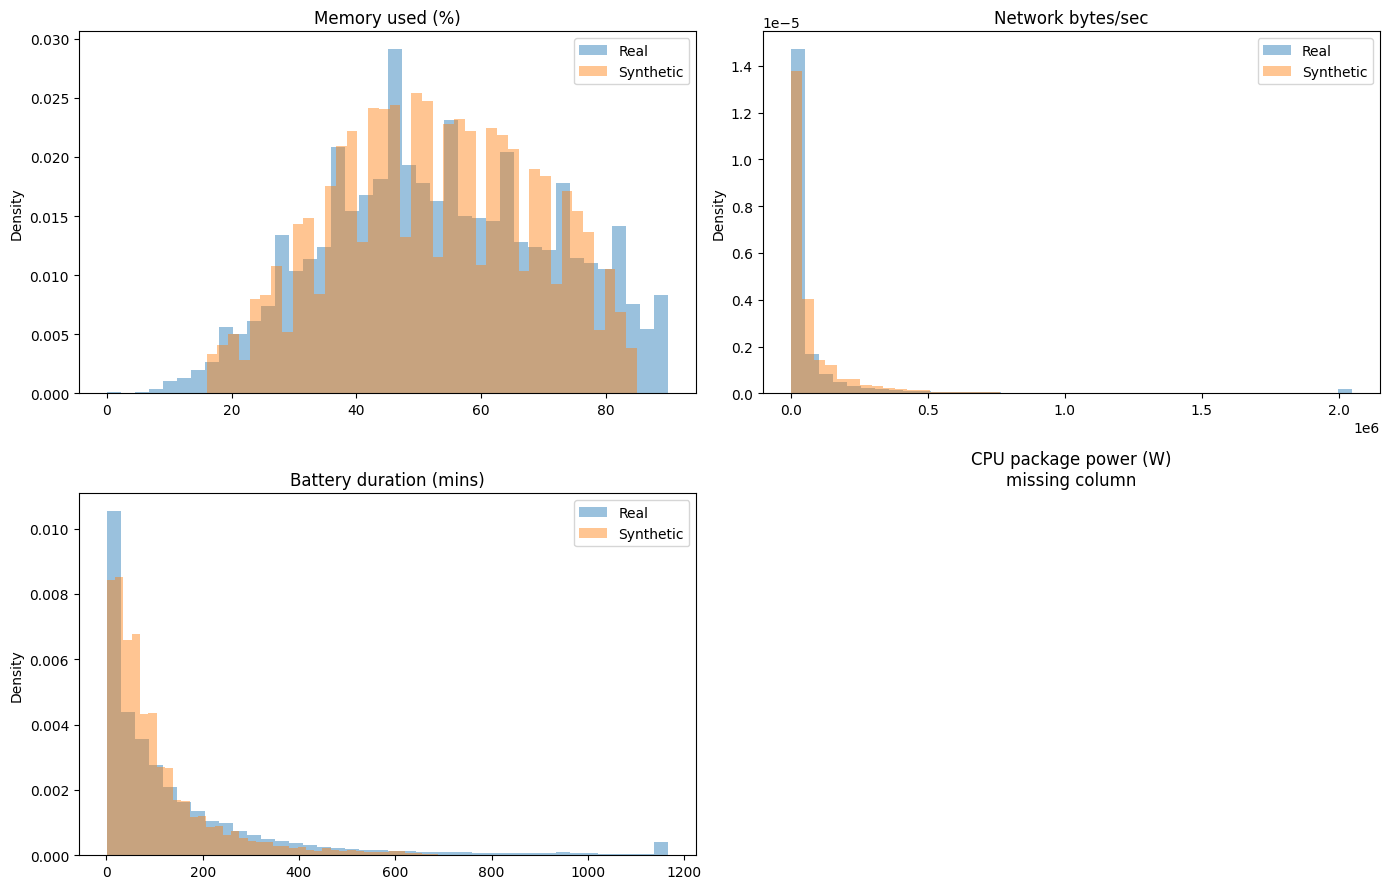

### Table-level categorical distributions

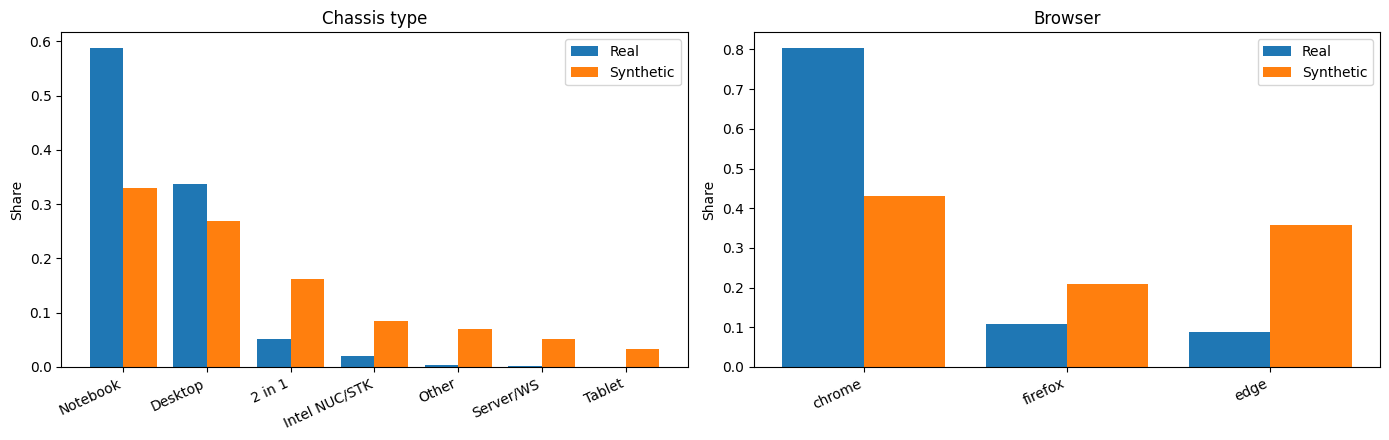

### Query-output distributions

#### ram_utilization_histogram

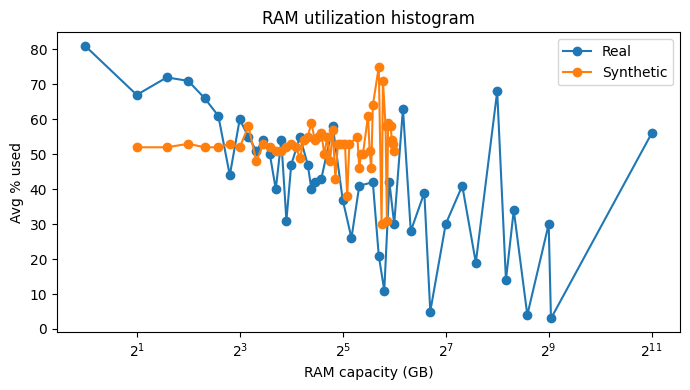

#### popular_browsers_by_count_usage_percentage

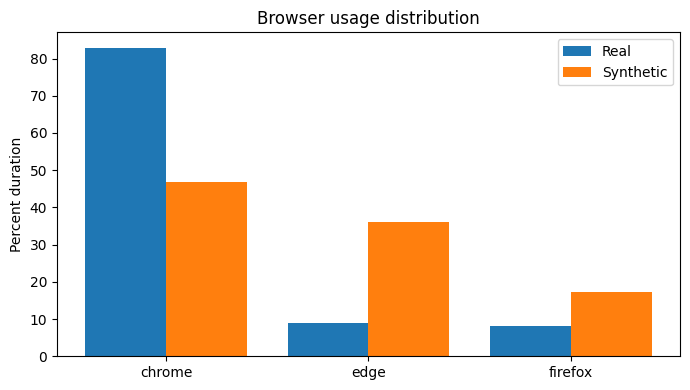

In [42]:
import matplotlib.pyplot as plt


def _load_real_synth_table(table_name):
    real_path = tables[table_name]["path"]
    synth_path = SYNTH_DIR / f"{table_name}.parquet"
    if not synth_path.exists():
        return None, None
    real_df = pd.read_parquet(real_path)
    synth_df = pd.read_parquet(synth_path)
    return real_df, synth_df


def _aligned_numeric_series(real_df, synth_df, col):
    r = pd.to_numeric(real_df[col], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    s = pd.to_numeric(synth_df[col], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    return r, s


def _topk_counts(df, col, k=8):
    vals = df[col].astype(str).fillna("Unknown")
    return vals.value_counts().head(k)


display(Markdown("### Table-level numeric distributions"))

numeric_specs = [
    ("system_memory_utilization", "avg_percentage_used", "Memory used (%)"),
    ("system_network_consumption", "avg_bytes_sec", "Network bytes/sec"),
    ("system_batt_dc_events", "duration_mins", "Battery duration (mins)"),
    ("system_hw_pkg_power", "avg_ia_power_watts", "CPU package power (W)"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes = axes.ravel()

for ax, (tname, col, title) in zip(axes, numeric_specs):
    real_df, synth_df = _load_real_synth_table(tname)
    if real_df is None:
        ax.set_title(f"{title}\nmissing synthetic table")
        ax.axis("off")
        continue
    if col not in real_df.columns or col not in synth_df.columns:
        ax.set_title(f"{title}\nmissing column")
        ax.axis("off")
        continue

    r, s = _aligned_numeric_series(real_df, synth_df, col)
    if len(r) == 0 or len(s) == 0:
        ax.set_title(f"{title}\nempty numeric data")
        ax.axis("off")
        continue

    clip_hi = float(np.nanpercentile(pd.concat([r, s]).values, 99))
    rr = r.clip(lower=0, upper=clip_hi)
    ss = s.clip(lower=0, upper=clip_hi)

    bins = 40
    ax.hist(rr, bins=bins, density=True, alpha=0.45, label="Real")
    ax.hist(ss, bins=bins, density=True, alpha=0.45, label="Synthetic")
    ax.set_title(title)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()


display(Markdown("### Table-level categorical distributions"))

cat_specs = [
    ("system_sysinfo_unique_normalized", "chassistype", "Chassis type"),
    ("system_web_cat_usage", "browser", "Browser"),
]

fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

for ax, (tname, col, title) in zip(axes, cat_specs):
    real_df, synth_df = _load_real_synth_table(tname)
    if real_df is None or col not in real_df.columns or col not in synth_df.columns:
        ax.set_title(f"{title}\nmissing data")
        ax.axis("off")
        continue

    r_counts = _topk_counts(real_df, col, k=8)
    s_counts = _topk_counts(synth_df, col, k=8)
    cats = list(dict.fromkeys(list(r_counts.index) + list(s_counts.index)))[:8]

    r = np.array([r_counts.get(c, 0) for c in cats], dtype=float)
    s = np.array([s_counts.get(c, 0) for c in cats], dtype=float)
    r = r / r.sum() if r.sum() > 0 else r
    s = s / s.sum() if s.sum() > 0 else s

    x = np.arange(len(cats))
    w = 0.4
    ax.bar(x - w / 2, r, width=w, label="Real")
    ax.bar(x + w / 2, s, width=w, label="Synthetic")
    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=25, ha="right")
    ax.set_ylabel("Share")
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()


display(Markdown("### Query-output distributions"))

q_pairs = [
    "ram_utilization_histogram",
    "popular_browsers_by_count_usage_percentage",
]

for q in q_pairs:
    real_path = RESULTS_REAL / f"{q}.csv"
    synth_path = RESULTS_SYNTH / f"{q}.csv"
    if not real_path.exists() or not synth_path.exists():
        display(Markdown(f"`{q}` missing real or synthetic csv"))
        continue

    real_q = pd.read_csv(real_path)
    synth_q = pd.read_csv(synth_path)
    display(Markdown(f"#### {q}"))

    if q == "ram_utilization_histogram":
        x_candidates = ["sysinfo_ram", "ram_gb", "ram"]
        y_candidates = ["avg_percentage_used", "avg_pct_used", "percentage_used"]
        xcol = next((c for c in x_candidates if c in real_q.columns and c in synth_q.columns), None)
        ycol = next((c for c in y_candidates if c in real_q.columns and c in synth_q.columns), None)

        if xcol is None or ycol is None:
            display(Markdown(f"`{q}` missing expected RAM columns. real={list(real_q.columns)}, synth={list(synth_q.columns)}"))
        else:
            real_plot = real_q[[xcol, ycol]].copy()
            synth_plot = synth_q[[xcol, ycol]].copy()

            fig, ax = plt.subplots(figsize=(7, 4))
            ax.plot(real_plot[xcol], real_plot[ycol], marker="o", label="Real")
            ax.plot(synth_plot[xcol], synth_plot[ycol], marker="o", label="Synthetic")
            ax.set_xscale("log", base=2)
            ax.set_xlabel("RAM capacity (GB)")
            ax.set_ylabel("Avg % used")
            ax.set_title("RAM utilization histogram")
            ax.legend()
            plt.tight_layout()
            plt.show()

    if q == "popular_browsers_by_count_usage_percentage":
        key = "browser"
        metric_candidates = ["percent_duration", "pct_duration", "duration_pct"]
        metric = next((c for c in metric_candidates if c in real_q.columns and c in synth_q.columns), None)

        if key not in real_q.columns or key not in synth_q.columns or metric is None:
            display(Markdown(f"`{q}` missing expected browser columns. real={list(real_q.columns)}, synth={list(synth_q.columns)}"))
        else:
            real_plot = real_q[[key, metric]].copy()
            synth_plot = synth_q[[key, metric]].copy()
            merged = real_plot.merge(synth_plot, on=key, how="outer", suffixes=("_real", "_synth")).fillna(0)

            fig, ax = plt.subplots(figsize=(7, 4))
            x = np.arange(len(merged))
            w = 0.4
            ax.bar(x - w / 2, merged[f"{metric}_real"], width=w, label="Real")
            ax.bar(x + w / 2, merged[f"{metric}_synth"], width=w, label="Synthetic")
            ax.set_xticks(x)
            ax.set_xticklabels(merged[key])
            ax.set_ylabel("Percent duration")
            ax.set_title("Browser usage distribution")
            ax.legend()
            plt.tight_layout()
            plt.show()